<a href="https://colab.research.google.com/github/root-epifit/madmo-adv/blob/my_exercise/hw2_poetry_generation_my_solutiuon_char_based_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2

## Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading
2. Dictionary generation
3. Data preprocessing
4. Model (neural network) training
5. Text generation (model evaluation)

### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

**Alternatively**

You could use file `onegin.txt` with Russian texts or your natve language poetry to be able to assess results quality.

**Note: In case of Onegin text you need to adjust reading procedure yourself!!!** (this file has a bit different format than `sonnets.txt`)

In [ ]:
!wget -nc https://raw.githubusercontent.com/v-goncharenko/madmo-adv/55d929befa12370fc18109f5333f7cf000ea27ce/homeworks/sonnets.txt
!wget -nc https://raw.githubusercontent.com/v-goncharenko/madmo-adv/55d929befa12370fc18109f5333f7cf000ea27ce/homeworks/onegin.txt

File ‘sonnets.txt’ already there; not retrieving.

File ‘onegin.txt’ already there; not retrieving.



In [ ]:
with open("sonnets.txt", "r") as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

In [ ]:
text[:20]

['  From fairest creatures we desire increase,\n',
 "  That thereby beauty's rose might never die,\n",
 '  But as the riper should by time decease,\n',
 '  His tender heir might bear his memory:\n',
 '  But thou, contracted to thine own bright eyes,\n',
 "  Feed'st thy light's flame with self-substantial fuel,\n",
 '  Making a famine where abundance lies,\n',
 '  Thy self thy foe, to thy sweet self too cruel:\n',
 "  Thou that art now the world's fresh ornament,\n",
 '  And only herald to the gaudy spring,\n',
 '  Within thine own bud buriest thy content,\n',
 "  And tender churl mak'st waste in niggarding:\n",
 '    Pity the world, or else this glutton be,\n',
 "    To eat the world's due, by the grave and thee.\n",
 '\n',
 '  II\n',
 '\n',
 '  When forty winters shall besiege thy brow,\n',
 "  And dig deep trenches in thy beauty's field,\n",
 "  Thy youth's proud livery so gazed on now,\n"]

In [ ]:
with open("onegin.txt", "r") as iofile:
    otext = iofile.readlines()

for i, token in enumerate(otext):
    otext[i] = token.replace('\t',' ')
#TEXT_START = 45
#TEXT_END = -368
#text = text[TEXT_START:TEXT_END]
assert len(otext) == 7088

In [ ]:
len(otext)

7088

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
import string

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

text = ''.join(text).lower()

assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
assert not any([x in set(text) for x in string.ascii_uppercase]), "Uppercase letters are present"
print("OK!")

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here
token_to_idx = {char:i for i, char in enumerate(tokens) }

# dict <char>:<index>
# Your great code here

idx_to_token = {i:char for i, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

### Data preparation

* Read text from file, lowercasing and replacing \n with EOS constant
* Tokenize - split text to tokens

After then we will work with that list of token instead of original text

###### imports

In [ ]:
import pandas as pd
from string import punctuation #сборник символов пунктуации

from string import punctuation #сборник символов пунктуации
from nltk.tokenize import word_tokenize #для токенизации по словам
from nltk.corpus import stopwords #сборник стоп-слов
#import pymorphy2 #для морфологическтого анализа текста
from nltk.probability import FreqDist #используется для кодирования «частотных распределений»

import nltk
nltk.download('punkt')
nltk.download('stopwords')

import numpy as np
from matplotlib import pyplot as plt


from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
EOS = 'eos'

import string

with open("onegin.txt", "r") as iofile:
    text = iofile.readlines()

# Convert to lowercase & replace '\t', \n' with ''
text = [token.lower().
        replace('\t', '').
        #replace(',\n',' ').
        #replace('.\n',' ').
        #replace(':\n',' ').
        replace('\n',f' {EOS} ').
        replace('«',' ').
        replace('»',' ').
        replace(', ',' ').
        replace('. ',' ').
        replace('! ',' ').
        replace('? ',' ').
        replace(': ',' ')  for token in text]

# Drop empy strings
text = [token for token in text if token != ' ']
    
# Convert to string
text = ''.join(text)

text

' eos i eos  eos  мой дядя самых честных правил eos когда не в шутку занемог eos он уважать себя заставил eos и лучше выдумать не мог eos его пример другим наука; eos но боже мой какая скука eos с больным сидеть и день и ночь eos не отходя ни шагу прочь eos какое низкое коварство eos полуживого забавлять eos ему подушки поправлять eos печально подносить лекарство eos вздыхать и думать про себя eos когда же черт возьмет тебя  eos  eos  eos  eos ii eos  eos так думал молодой повеса eos летя в пыли на почтовых eos всевышней волею зевеса eos наследник всех своих родных — eos друзья людмилы и руслана eos с героем моего романа eos без предисловий сей же час eos позвольте познакомить вас eos онегин добрый мой приятель eos родился на брегах невы eos где может быть родились вы eos или блистали мой читатель; eos там некогда гулял и я eos но вреден север для меня eos  eos  eos iii eos  eos служив отлично-благородно eos долгами жил его отец eos давал три бала ежегодно eos и промотался наконец eos 

In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

###### Tokenize text

In [ ]:
# Делим текст на токены, выкидываем из них знаки препинания 
# Стоп-слова оставляем, т.к. если их выкинуть, то стихи не получатся

#STOPWORD = stopwords.words('russian') + [a for a in punctuation]
STOPWORD = [a for a in punctuation] + ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii',
                                       'viii', 'ix', 'x', 'xi', 'xii', 'xiii',
                                       'xiv', 'xv', 'xvi', 'xvii', 'xviii', 
                                       'xix', 'xx', 'xlvi']

def tokenize(text:string) -> list: 
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in STOPWORD]
    # delete subsequent eos
    prev_token = ''
    out_list = []
    for token in tokens:
        current_token = token
        if prev_token == EOS and current_token == EOS:
            continue
        else:
            if current_token == EOS:
                # К EOS не добавляем пробел
                out_list.append('\n')
            else:
                # К остальным добавляем пробел
                out_list.append(current_token+' ')

        prev_token = token
    return out_list    
    # Преобразовываем слова в словоформы
    #morph = pymorphy2.MorphAnalyzer()
    #return [morph.parse(item)[0].normal_form for item in tokens]
    #return tokens #[char for char in text if char not in STOPWORD]

def tokens_to_text(tokens:list) -> str:
    return(''.join(tokens).replace(' '+EOS,'\n').replace(EOS,'\n'))

def get_uniq_chars(tokens)-> set:
    chars = [_ for _ in tokens_to_text(tokens)]
    return sorted(set(chars))

text_as_tokens = tokenize(text)
print("\n text_as_tokens")
print(tokens_to_text(text_as_tokens[:100]))

dictionary = get_uniq_chars(text_as_tokens)
print(f'\n\nlen(dictionary) = {len(dictionary)}')
print(f"dictionry: {dictionary[:10]}")
print("")

print(f'len(text_as_tokens) = {len(text_as_tokens)}')
print(f'text_as_tokens[:20]: {text_as_tokens[:20]}')
print("")

# token_to_idx / idx_to_token encoding
char_to_idx = {char:i for i, char in enumerate(dictionary)}

print(f'len(char_to_idx) = {len(char_to_idx)}')
print(f'{char_to_idx}')
print("")

idx_to_char = {i:char for i, char in enumerate(dictionary)}
print(f'len(idx_to_char) = {len(idx_to_char)}')
print(idx_to_char)


 text_as_tokens

мой дядя самых честных правил 
когда не в шутку занемог 
он уважать себя заставил 
и лучше выдумать не мог 
его пример другим наука 
но боже мой какая скука 
с больным сидеть и день и ночь 
не отходя ни шагу прочь 
какое низкое коварство 
полуживого забавлять 
ему подушки поправлять 
печально подносить лекарство 
вздыхать и думать про себя 
когда же черт возьмет тебя 
так думал молодой повеса 
летя в пыли на почтовых 
всевышней волею зевеса 
наследник всех своих родных — 
друзья людмилы и 


len(dictionary) = 72
dictionry: ['\n', ' ', '-', '.', '5', '7', '8', '9', '^', 'a']

len(text_as_tokens) = 28313
text_as_tokens[:20]: ['\n', 'мой ', 'дядя ', 'самых ', 'честных ', 'правил ', '\n', 'когда ', 'не ', 'в ', 'шутку ', 'занемог ', '\n', 'он ', 'уважать ', 'себя ', 'заставил ', '\n', 'и ', 'лучше ']

len(char_to_idx) = 72
{'\n': 0, ' ': 1, '-': 2, '.': 3, '5': 4, '7': 5, '8': 6, '9': 7, '^': 8, 'a': 9, 'b': 10, 'c': 11, 'd': 12, 'e': 13, 'f': 14, 'g': 15, 'h': 16, 'i': 1

###### Coding text  

[[0], [46, 48, 43, 1], [38, 65, 38, 65, 1], [51, 34, 46, 61, 55, 1], [57, 39, 51, 52, 47, 61, 55, 1], [49, 50, 34, 36, 42, 45, 1], [0], [44, 48, 37, 38, 34, 1], [47, 39, 1], [36, 1], [58, 53, 52, 44, 53, 1], [41, 34, 47, 39, 46, 48, 37, 1], [0], [48, 47, 1], [53, 36, 34, 40, 34, 52, 62, 1], [51, 39, 35, 65, 1], [41, 34, 51, 52, 34, 36, 42, 45, 1], [0], [42, 1], [45, 53, 57, 58, 39, 1], [36, 61, 38, 53, 46, 34, 52, 62, 1], [47, 39, 1], [46, 48, 37, 1], [0], [39, 37, 48, 1], [49, 50, 42, 46, 39, 50, 1], [38, 50, 53, 37, 42, 46, 1], [47, 34, 53, 44, 34, 1], [0], [47, 48, 1], [35, 48, 40, 39, 1], [46, 48, 43, 1], [44, 34, 44, 34, 65, 1], [51, 44, 53, 44, 34, 1], [0], [51, 1], [35, 48, 45, 62, 47, 61, 46, 1], [51, 42, 38, 39, 52, 62, 1], [42, 1], [38, 39, 47, 62, 1], [42, 1], [47, 48, 57, 62, 1], [0], [47, 39, 1], [48, 52, 55, 48, 38, 65, 1], [47, 42, 1], [58, 34, 37, 53, 1], [49, 50, 48, 57, 62, 1], [0], [44, 34, 44, 48, 39, 1], [47, 42, 41, 44, 48, 39, 1], [44, 48, 36, 34, 50, 51, 52, 36,

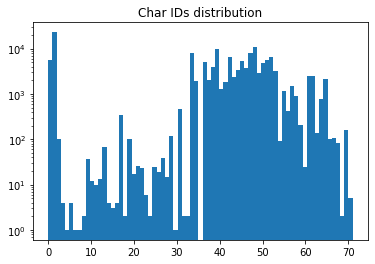

In [ ]:
# Кодируем текст sequence of idx
def to_seq(text_as_tokens):
    return [[char_to_idx[char] for char in token] for token in text_as_tokens]

def flatten(t):
    return [item for sublist in t for item in sublist]
    
text_as_seq_of_idx = to_seq(text_as_tokens)
print(text_as_seq_of_idx)
print(flatten(text_as_seq_of_idx))
print(f'Total num chars:{len(flatten(text_as_seq_of_idx))}')

plt.title('Char IDs distribution')
plt.hist(flatten(text_as_seq_of_idx), bins=len(dictionary)+1)
plt.yscale('log')
plt.show()

In [ ]:
# Let's look at top frequent tokens

import pandas as pd
df = pd.DataFrame(np.histogram(flatten(text_as_seq_of_idx), 
                               bins=max(flatten(text_as_seq_of_idx)
                               )))
df = df.transpose()
df['token'] = df[1].apply(lambda x: idx_to_char[x])
df.sort_values(by=0, ascending=False).head(10)

,0,1,token
1,22844.0,1.0,
48,10973.0,48.0,о
39,9534.0,39.0,е
34,8071.0,34.0,а
47,7984.0,47.0,н
42,6648.0,42.0,и
52,6499.0,52.0,т
0,5469.0,0.0,\n
51,5458.0,51.0,с
45,5335.0,45.0,л


In [ ]:
# Calculated matrix of weights to be used in loss function
# The most frequent tokens will get penalty
#

hist, bin_edges = np.histogram(text_as_seq_of_idx, bins=max(text_as_seq_of_idx)+1)

idx_weights = hist/hist.max()

def calc_weights(sequence):
    hist, bin_edges = np.histogram(text_as_seq_of_idx, bins=max(text_as_seq_of_idx)+1)
    idx_weights = np.tanh(hist)
    return [idx_weights[token_to_idx[item]] for item in sequence]

weights_for_dictionary = calc_weights(dictionary)

# Check weights for EOS
#np.array(weights_for_dictionary)[np.where(np.array(dictionary) == EOS)]

In [ ]:
weights_for_dictionary
print(dictionary[:100])
hist[5]
print([idx_to_token[id] for id in text_as_seq_of_idx][:100])

In [ ]:
# Let delete from text_as_seq_idx tokens = [и]
#print(f'before = {text_as_seq_of_idx.shape}')
#text_as_seq_of_idx = np.delete(text_as_seq_of_idx, np.where(text_as_seq_of_idx == 1506))
#print(f'after = {text_as_seq_of_idx.shape}')

In [ ]:
# get_batch

SEQ_LEN = 256                                                # in words
BATCH_SIZE = 16

def get_batch(sequence) -> torch.tensor:
    trains = []
    targets = []
    for _ in range(BATCH_SIZE):
        batch_start = np.random.randint(0, len(sequence) - SEQ_LEN)
        chunk = sequence[batch_start: batch_start + SEQ_LEN]

        train = torch.LongTensor(chunk[:-1]).view(-1, 1)
        #weight = torch.LongTensor(weight[:-1]).view(-1, 1)        
        target = torch.LongTensor(chunk[1:]).view(-1, 1)
        trains.append(train)
        #weights.append(weight)
        targets.append(target)
    return torch.stack(trains, dim=0), torch.stack(targets, dim=0) #torch.stack(weights, dim=0), 

trains, targets = get_batch(flatten(text_as_seq_of_idx))

for id in [0,1,5,10]:
    print(f'\ntrain[{id}] = {[idx_to_char[idx] for idx in trains[id,:100].flatten().tolist()]}')
    #print(f'weight[{id}] = {weights[id,:10].flatten().tolist()}')
    print(f'target[{id}] = {[idx_to_char[idx] for idx in targets[id,:100].flatten().tolist()]}')


train[0] = ['а', 'м', 'о', 'м', ' ', 'д', 'е', 'л', 'е', ' ', '\n', 'т', 'р', 'и', ' ', 'д', 'о', 'м', 'а', ' ', 'н', 'а', ' ', 'в', 'е', 'ч', 'е', 'р', ' ', 'з', 'о', 'в', 'у', 'т', ' ', '\n', 'т', 'а', 'м', ' ', 'б', 'у', 'д', 'е', 'т', ' ', 'б', 'а', 'л', ' ', 'т', 'а', 'м', ' ', 'д', 'е', 'т', 'с', 'к', 'и', 'й', ' ', 'п', 'р', 'а', 'з', 'д', 'н', 'и', 'к', ' ', '\n', 'к', 'у', 'д', 'а', ' ', 'ж', ' ', 'п', 'о', 'с', 'к', 'а', 'ч', 'е', 'т', ' ', 'м', 'о', 'й', ' ', 'п', 'р', 'о', 'к', 'а', 'з', 'н', 'и']
target[0] = ['м', 'о', 'м', ' ', 'д', 'е', 'л', 'е', ' ', '\n', 'т', 'р', 'и', ' ', 'д', 'о', 'м', 'а', ' ', 'н', 'а', ' ', 'в', 'е', 'ч', 'е', 'р', ' ', 'з', 'о', 'в', 'у', 'т', ' ', '\n', 'т', 'а', 'м', ' ', 'б', 'у', 'д', 'е', 'т', ' ', 'б', 'а', 'л', ' ', 'т', 'а', 'м', ' ', 'д', 'е', 'т', 'с', 'к', 'и', 'й', ' ', 'п', 'р', 'а', 'з', 'д', 'н', 'и', 'к', ' ', '\n', 'к', 'у', 'д', 'а', ' ', 'ж', ' ', 'п', 'о', 'с', 'к', 'а', 'ч', 'е', 'т', ' ', 'м', 'о', 'й', ' ', 'п', 'р', 'о'

##### Vanila RNN

In [ ]:
# Your code here
num_tokens = len(dictionary)

class WordRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """

    def __init__(self, num_tokens=len(dictionary), embedding_size=64, rnn_num_units=512):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        #self.rnn_fc2    = nn.Linear(rnn_num_units, rnn_num_units)
        self.dropout    = nn.Dropout(0.2)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)
        #print(x_emb.shape)
        #print(h_prev.shape)

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)  # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h)  # YOUR CODE HERE

        h_next = torch.tanh(h_next)  # YOUR CODE HERE
      
        #x_fc2  =  self.rnn_fc2(h_next)
        #out = torch.relu(x_fc2)
        out = self.dropout(h_next)

        # compute logits for next character probs
        #logits = self.rnn_to_logits(h_next)  # YOUR CODE
        logits = self.rnn_to_logits(out)
        return h_next, logits

    def initial_state(self, batch_size):
        """return rnn state before it processes first input (aka h0)"""
        return torch.zeros(batch_size, self.num_units, requires_grad=True)


# Instatiate the model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

word_rnn = WordRNNCell()
word_rnn.to(device)

#weight = torch.tensor(weights_for_dictionary, dtype=torch.float32)

#criterion = nn.NLLLoss(weight=weight)
#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(word_rnn.parameters())


In [ ]:
word_rnn

WordRNNCell(
  (embedding): Embedding(72, 64)
  (rnn_update): Linear(in_features=576, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn_to_logits): Linear(in_features=512, out_features=72, bias=True)
)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

###### Training

epoch = 199


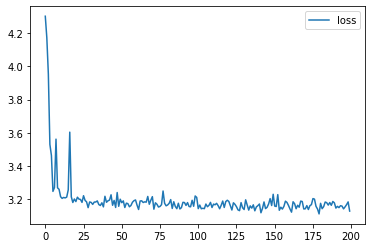

KeyboardInterrupt: ignored

In [ ]:
# Training

n_epoch = 2000


# Batch loop
def rnn_loop(char_rnn, train):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_ix = train.view(train.size()[0],-1)

    batch_size, max_length  = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))

    return torch.stack(logprobs, dim=1)

# Training loop

logprobs = []
history = []

for epoch in range(n_epoch):
    opt.zero_grad()

    train, target = get_batch(flatten(text_as_seq_of_idx))

    logp_seq = rnn_loop(word_rnn, train)
    
    # compute loss
    #predictions_logp = logp_seq[:, :-1]  # YOUR CODE HERE
    #predictions_logp = logp_seq[:, :]
    #actual_next_tokens = batch_ix[:, 1:]  # YOUR CODE HERE

    predictions_logp = logp_seq
    actual_next_tokens = target.view(target.size()[0],-1).transpose(0,1)

    #     print(predictions_logp.shape, actual_next_tokens.shape)
    loss = criterion(
        predictions_logp.contiguous().view(-1, len(dictionary)),
        actual_next_tokens.contiguous().view(-1),
    )
    # YOUR CODE HERE

    # train with backprop
    loss.backward()
    opt.step()

    # YOUR CODE HERE

    history.append(loss.data.numpy())
    if (epoch + 1) % 50 == 0:
        clear_output(True)
        print(f'epoch = {epoch}')
        #print(generate_text(model = word_rnn, 
        #          words="Онегин", 
        #          length=100, 
        #          temperature=0.3))

        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

#assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
# Generate sample

MAX_LENGTH = 256

def generate_text(model = word_rnn, 
                  words:str=' ', 
                  length=MAX_LENGTH, 
                  temperature=0.3):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    char_rnn = model
    max_length = length

    #seed_length = 3
    #start = np.random.randint(0, len(dictionary) - seed_length - 1)
    #stop  = start + seed_length
    #words = words or " ".join(dictionary[start:stop])

    x_sequence = flatten(to_seq(tokenize(words.lower()))) 

    print(''.join([idx_to_char[_] for _ in x_sequence])) 

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    # feed the seed phrase, if any
    for i in range(len(x_sequence) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(x_sequence)):
        #print(f'iteration={_}')
        #s=[idx_to_token[_].replace('eos','\n') for _ in x_sequence[:,-1].data.numpy()]
        #print(f"input = {s}")
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(dictionary), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        #print(next_ix, next_ix.shape)
        #print(x_sequence, x_sequence.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1) if next_ix[0,0] != x_sequence[0,-1::] else x_sequence

    return ''.join([idx_to_char[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
# An example of generated text. There is no function `generate_text` in the code above.
print(generate_text(length=256, temperature=0.3, words="зима"))

зима 
зима ос
ен у ае о о ов е о т н ео е н т о о о о ое о на а н о е о н л е еои ев о о о и е е д о а ао о о е ие аен р


###### Loss plot

epoch = 999


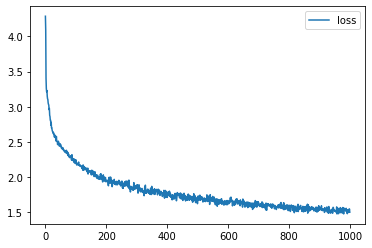

In [ ]:
# Your plot code here
clear_output(True)
print(f'epoch = {epoch}')
plt.plot(history, label="loss")
plt.legend()
plt.show()

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here

In [ ]:
class lstmRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, embedding_size, n_layers=1):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(self.input_size, self.embedding_size)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.n_layers)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.hidden_size, self.input_size)
        
    def forward(self, x, hidden):
        x = self.encoder(x).squeeze(2)
        out, (ht1, ct1) = self.lstm(x, hidden)
        out = self.dropout(out)
        x = self.fc(out)
        return x, (ht1, ct1)
    
    def init_hidden(self, batch_size=1):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True).to(device),
               torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True).to(device))

epoch = 999


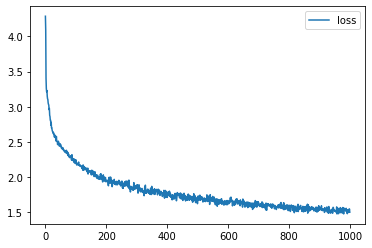

In [ ]:
from matplotlib import pyplot as plt 
from IPython.display import clear_output

model = lstmRNN(input_size=len(char_to_idx), hidden_size=128, embedding_size=64, n_layers=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
#criterin = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience=5, 
    verbose=True, 
    factor=0.5
)

n_epochs = 1000       
loss_avg = []
history = []

for epoch in range(n_epochs):
    #print(f'epoch = {epoch}')
    model.train()
    train, target = get_batch(flatten(text_as_seq_of_idx))
    train = train.permute(1, 0, 2).to(device)
    target = target.permute(1, 0, 2).to(device)
    hidden = model.init_hidden(BATCH_SIZE)

    output, hidden = model(train, hidden)
    loss = criterion(output.permute(1, 2, 0), target.squeeze(-1).permute(1, 0))
    #break;   
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
        
    history.append(loss.data.numpy())
    if (epoch + 1) % 50 == 0:
        clear_output(True)
        print(f'epoch = {epoch}')
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

Generate text using the trained net with different `temperature` parameter: `(0.1, 0.2, 0.5, 1.0, 2.0)`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here

In [ ]:
def generate_text_lstm(model=model, 
                       char_to_idx=char_to_idx, 
                       idx_to_char=idx_to_char, 
                       start_text=' ', prediction_len=256, temperature=0.3):
    hidden = model.init_hidden()
    idx_input = [char_to_idx[char] for char in start_text]
    train = torch.LongTensor(idx_input).view(-1, 1, 1).to(device)
    predicted_text = start_text
    
    _, hidden = model(train, hidden)
        
    inp = train[-1].view(-1, 1, 1)
    
    for i in range(prediction_len):
        output, hidden = model(inp.to(device), hidden)
        output_logits = output.cpu().data.view(-1)
        p_next = F.softmax(output_logits / temperature, dim=-1).detach().cpu().data.numpy()        
        top_index = np.random.choice(len(char_to_idx), p=p_next)
        inp = torch.LongTensor([top_index]).view(-1, 1, 1).to(device)
        predicted_char = idx_to_char[top_index]
        predicted_text = predicted_text + predicted_char if predicted_char != predicted_text[len(predicted_text)-1] else predicted_text 
    
    return predicted_text

In [ ]:
for temp in (0.1, 0.2, 0.5, 1.0, 2.0):
    print(f"\n\n====================")
    print(f"temperature={temp}")
    print(generate_text_lstm(start_text='прости',temperature = temp, prediction_len=128).
          replace(' \n \n','\n').replace(' \n \n','\n').replace(' \n \n','\n'))



temperature=0.1
прости 
в свои полно простости молод 
и скоро страстный в старины 
и в ней страстный взор был свободы 
не полно простите с ней 
татьян


temperature=0.2
прости 
с ним долго посланье со луна 
и в сорок и смело поэта 
и в стариных полный ленский забвенье 
не подобно в ней судьба 
с ней н


temperature=0.5
прости 
снег суровый кажется… за стал 
его отстав на скука невель 
и не не приятелиц и долго 
последников поклоно след 
с куков так и


temperature=1.0
прости — 
приечное песни богу 
ты во холодный леной — 
опяты поздно прежнием тень 
потом ли в угадки знарьный 
да несотрыться 
как вов


temperature=2.0
прости блежу чтоем 
xlvi 
однеыт биледый нохопью ’iв 
уяхаяпи днем с9ели 
с тогильигпи5ц обхотаюсь 
жуснаснясит т носе тую 
фврык бр


### Saving and loading models

Save the model to the disk, then load it and generate text.
Follow guides from [this tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

You need to use `Save/Load state_dict (Recommended)` section aka save state dict.

In [ ]:
# Saving and loading code here

# Save the model
torch.save(model.state_dict(), 'hw2_lstm_model.pt')

# Load the model
model = lstmRNN(input_size=len(char_to_idx), hidden_size=128, embedding_size=128, n_layers=2)
model.load_state_dict(torch.load('hw2_lstm_model.pt'))
model.eval()

lstmRNN(
  (encoder): Embedding(72, 128)
  (lstm): LSTM(128, 128, num_layers=2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=72, bias=True)
)

In [ ]:
print(generate_text_lstm())

 таня 
он полужна не страной том 
но в поле стариный конечно 
не может может и того же 
и скучая пора 
как сани простите во дней 
и скажи была перед ней 
и в своей рукою полна 
и всё думать был сердце страстной 
не предвижу полона 
у них не строщал своей 


## Additional materials on topic

1. [Andrew Karpathy blog post about RNN.](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)\
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with [PyTorch examples](https://github.com/spro/practical-pytorch`)